# Data exploration and descriptive statistics of satellite imagery

This jupyter notebook will parse, collate and analyze satellite imagery files from Maxar (former DigitalGlobe) The parsing of the metadata files (`DeliveryMetadata.xml`) are mainly general and should work for any Maxar product delivery. After parsing of the metadata files into pandas dataframes the code is mainly project specific.

## Imports and setup

In [ ]:
import numpy as np
import pandas as pd
import os
from modules.metadata_reader import img_metadata_to_dict, add_names_to_metadata_dict, dict_to_df

# Path to location where individual satellite images are located
DATA_PATH = 'data' 
DATA_PATH_IS_RELATIVE = True

# Name of metadata .xml file
METADATA_NAME = 'DeliveryMetadata.xml'

# Names of areas covered by satellite imagery
AREAS = ['La_Spezia', 'Toulon'] # Spelled like the directory names

# Speficy what the xmlns url on top of metadata .xml file is
# (should be second line)
XMLNS = 'http://xsd.digitalglobe.com/xsd/dm'

## Metadata parsing from xml to pandas dataframe

Every satellite image delivery from Maxar contains a `DeliveryMetadata.xml` file with important specifications for both the multispectral and panchromatic images. The following functions finds all the `DeliveryMetadata.xml` files contained in all subdirectories of a directory and parses them into the *Pandas DataFrame* format which will be used for further descriptive statistics of the dataset.

In [ ]:
img_metadata_pan, img_metadata_ms = img_metadata_to_dict(METADATA_NAME, 
                                                         DATA_PATH, XMLNS, 
                                                         path_is_relative = DATA_PATH_IS_RELATIVE)

img_metadata_pan = add_names_to_metadata_dict(img_metadata_pan, AREAS)
img_metadata_ms = add_names_to_metadata_dict(img_metadata_ms, AREAS)

img_metadata_pan = dict_to_df(img_metadata_pan)
img_metadata_ms = dict_to_df(img_metadata_ms)

# Distribution of images

## Some quick sanity checks

In [ ]:
print('Number of panchromatic images:', len(img_metadata_pan))
print('Number of multispectral images:', len(img_metadata_ms), '\n')
if list(img_metadata_pan.index.values) == list(img_metadata_ms.index.values):
    print('Pass: Identical keys. Keys in panchromatic and multispectral dictionaries are identical.')
else: print('Fail: Identical keys. Keys in panchromatic and multispectral dictionaries are not identical.')

Number of panchromatic images: 74
Number of multispectral images: 74 

Pass: Identical keys. Keys in panchromatic and multispectral dictionaries are identical.


## Histograms multispectral

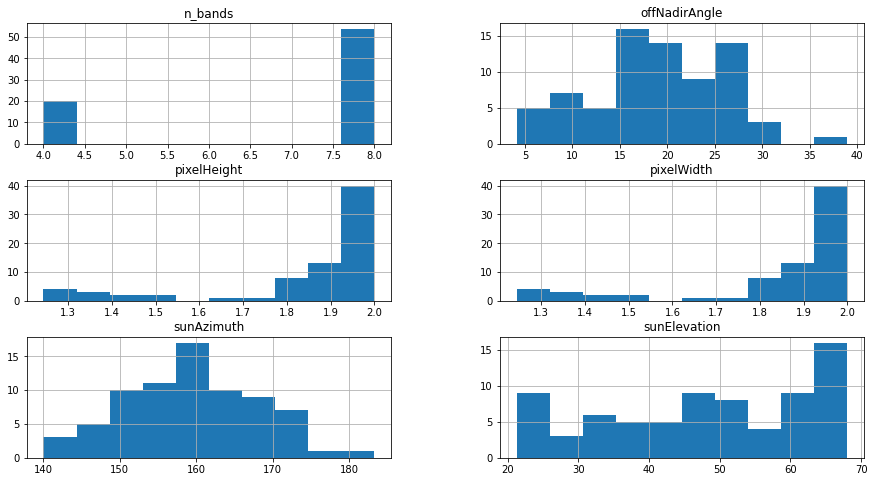

In [ ]:
hist_factors = ['pixelWidth', 
                'pixelHeight', 
                'n_bands',
                'offNadirAngle', 
                'sunAzimuth', 
                'sunElevation']
hist_ms = img_metadata_ms[hist_factors].hist(figsize=(15,8))

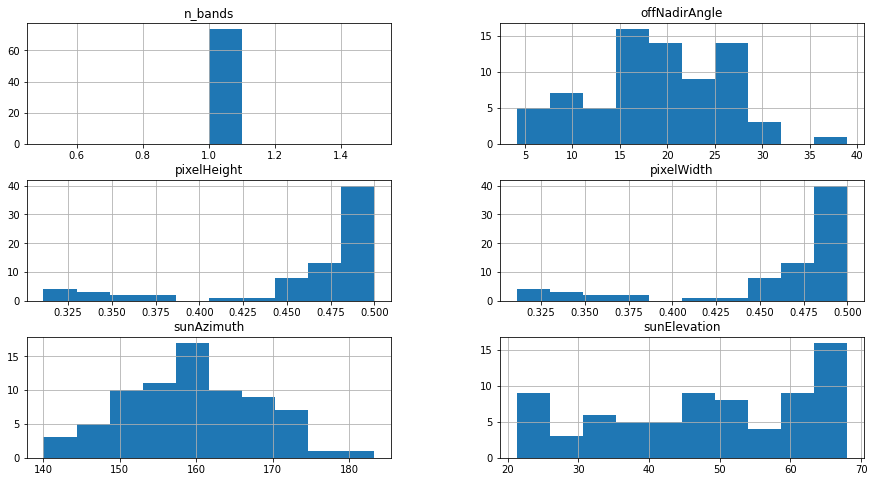

In [ ]:
hist_pan = img_metadata_pan[hist_factors].hist(figsize=(15,8))

## Contingency table Sensor x Area

In [ ]:
table = pd.crosstab(img_metadata_pan['area_name'], 
                    img_metadata_pan['sensorVehicle'], 
                    margins=True)
table

sensorVehicle,GE01,WV02,WV03_VNIR,All
area_name,,,,
La_Spezia,11,23,2,36
Toulon,9,20,9,38
All,20,43,11,74


## Clouds?
*TODO: Get a measure of clod coverage in every specific image. Either automatically based on available algorithms or manually since the number of images are limited.*

## Calculate actual area covered by each image
*TODO: Many images do not cover the whole area of interest. By using the parsed metadata dataframe and shape geometry supplied with every image it is possible to calculate the actual area. This number may nuance distribution of images across areas, sensors and clouds.*

# Randomly select two images for early trials

Before deciding on final train/validation/test split we randomly select two images from Toulon taken by the WorldView02 (WV02) sensor. These two images will in the future be inclued in the training partition. We do this in order to get started with early trials without compromising the validity of test results by experimenting on images that in the future will be used for testing.

In [ ]:
toulon_wv02_pan = img_metadata_pan[(img_metadata_pan['sensorVehicle'] == 'WV02')
                                   & (img_metadata_pan['area_name'] == 'Toulon')]

In [ ]:
np.random.seed(1)
img_names = sorted(toulon_wv02_pan.index.values)
np.random.shuffle(img_names)
images_for_early_trials = img_names[:2]
images_for_early_trials

['WV02_Toulon_2013_03_16_011651062010_0',
 'WV02_Toulon_2019_08_04_011650878010_0']